## Import Dependencies

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


from pathlib import Path
import pathlib
from PIL import Image
import itertools
import re

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
%matplotlib inline 

In [5]:
import pandas as pd 
import re
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
tqdm.pandas();

## Define Directory Paths
### Input Directories

In [6]:
train_dir = Path('../archive/SN7_buildings_train')
test_dir = Path('../archive/SN7_buildings_test_public')
sample_dir = Path('../archive/SN7_buildings_train_sample')
train_dir

WindowsPath('../archive/SN7_buildings_train')

### Output Paths

In [7]:
output_path = Path.cwd()
output_csv_path = output_path/'output_csvs/'
Path(output_csv_path).mkdir(parents=True, exist_ok=True)

In [8]:
def extract_metadata_from_string(string):
    # extracted groups
    # full path - image_dir_name - sub_dir_name - fname - year - month - data_type - extension
    pattern = r'/(t.+|sample)/(L.+)/(\w+)/(.+_(\d+)_(\d+)_m.+_\d+_\d+_\d+)(?:_(\w+))?.(\w+)'
    match = re.findall(pattern=pattern,string=string)
    if match:
        return match[0]
    

In [9]:
string1 = '../archive/SN7_buildings_train/train/L15-1389E-1284N_5557_3054_13/labels_match/global_monthly_2020_01_mosaic_L15-1389E-1284N_5557_3054_13_Buildings.geojson'
string2 = '../archive/SN7_buildings_train_sample/sample/L15-0506E-1204N_2027_3374_13/UDM_masks/global_monthly_2019_11_mosaic_L15-0506E-1204N_2027_3374_13.tif'


In [10]:
extract_metadata_from_string(string1)

('train',
 'L15-1389E-1284N_5557_3054_13',
 'labels_match',
 'global_monthly_2020_01_mosaic_L15-1389E-1284N_5557_3054_13',
 '2020',
 '01',
 'Buildings',
 'geojson')

In [12]:
extract_metadata_from_string(string2)

('sample',
 'L15-0506E-1204N_2027_3374_13',
 'UDM_masks',
 'global_monthly_2019_11_mosaic_L15-0506E-1204N_2027_3374_13',
 '2019',
 '11',
 '',
 'tif')

In [13]:
def extract_list_of_paths(directory):
    paths_list = [path for path in Path.glob(directory,pattern = '**/*.*')]
    return paths_list

In [14]:
def extract_metadata_from_list_of_paths(list_of_paths):
    d_keys = ['parent_dir','image_dir_name','sub_dir_name','fname','year','month','data_type','extension']
    d = {key:[] for key in d_keys}
    d['full_path'] = []
    for path in list_of_paths:
        #print(str(path))
        metadata = extract_metadata_from_string(str(path))
        if metadata != None:
            d['full_path'].append(path)
            
            for i,data in enumerate(metadata):
                d[d_keys[i]].append(data)
    return d

### Extracting the Metadata
The function below will extract a list of the paths of the files inside of the input directory

In [15]:
train_paths = extract_list_of_paths(directory=train_dir)
test_paths = extract_list_of_paths(directory=test_dir)
sample_paths = extract_list_of_paths(directory=sample_dir)


In [16]:
train_metadata_dict = extract_metadata_from_list_of_paths(train_paths)
test_metadata_dict = extract_metadata_from_list_of_paths(test_paths)
sample_metadata_dict = extract_metadata_from_list_of_paths(sample_paths)

In [17]:
df_train = pd.DataFrame(train_metadata_dict)
df_test = pd.DataFrame(test_metadata_dict)
df_sample = pd.DataFrame(sample_metadata_dict)

In [18]:
df_train

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path


In [19]:
df_test

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path


In [20]:
df_sample

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path


In [21]:
df_train[df_train['data_type'] == 'Buildings']['extension'].value_counts()

Series([], Name: count, dtype: int64)

In [22]:
df_train[df_train['data_type'] == 'UDM']['extension'].value_counts()

Series([], Name: count, dtype: int64)

In [23]:
df_train[df_train['data_type'] == '']['extension'].value_counts()

Series([], Name: count, dtype: int64)

As you may have noticed some of our data types are giving us a value of `''`. This is because as mentioned earlier the files that are actually images or `.tif` files do not have a datatype at the end. 

In order to remedy this problem we will simple replace the values = `''` with the value of `Images`

In [24]:
df_train.loc[df_train['data_type'] =='','data_type'] = 'Images'
df_test.loc[df_test['data_type'] =='','data_type'] = 'Images'
df_sample.loc[df_sample['data_type'] =='','data_type'] = 'Images'

In [25]:
df_train

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path


In [26]:
df_test

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path


In [27]:
df_sample

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path


Finally, let's create a function that automates all the steps above.

In [28]:
def get_metadata(input_dir):
    list_of_paths = extract_list_of_paths(input_dir)
    metadata_dict = extract_metadata_from_list_of_paths(list_of_paths)
    df = pd.DataFrame(metadata_dict)
    
    df.loc[df['data_type'] =='','data_type'] = 'Images'
    

    # Identify Images that have UDM Masks
    condition = (df['sub_dir_name'] == 'UDM_masks')
    # Get the indices of the images that have udm
    udm_indices = df.loc[condition].index
    # Get list of unique file names that have UDMs
    udm_fnames = list(df.loc[udm_indices,'fname'])
    # Get all rows that match the file names
    udm_mask = df['fname'].progress_map(lambda x: x in udm_fnames)
    # Initialize has_udm column 
    df['has_udm'] = False
    # Apply mask and update udm value
    df.loc[udm_mask,'has_udm'] = True

    return df

## Saving the Outputs
Finally we are going to save the output dataframes as csvs. We are going to have 4 csvs in total:
* CSV for the train dataframe
* CSV for the test dataframe
* CSV for the sample dataframe
* CSV for the concatenated train, test and sample dataframes

In [29]:
df_train = get_metadata(train_dir)
df_test = get_metadata(test_dir)
df_sample = get_metadata(sample_dir)
df_concat = pd.concat([df_train,df_test,df_sample]).reset_index()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [30]:
df_train.to_csv(output_csv_path/'df_train.csv',index=False)
df_test.to_csv(output_csv_path/'df_test.csv',index=False)
df_sample.to_csv(output_csv_path/'df_sample.csv',index=False)
df_concat.to_csv(output_csv_path/'df_concat.csv',index=False)

In [31]:
df_test.head()

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path,has_udm


Let's make sure that the output is saved

In [32]:
!ls ./output_csvs

'ls' is not recognized as an internal or external command,
operable program or batch file.


Okay so now we have saved the first version of our csv, our csv is formatted in a format known as tidy data. This format, makes it really easy to analyse our metadata. Next we are going to manipulate our dataframe so that we can make it easier to create a dataset class from it in pytorch.

We are going to do this by adding a column for each of the labels paths.

In [33]:
def untidy_df(df):
    
    parent_dir = df['parent_dir']
    im_dir_name = df['image_dir_name']
    fname = df['fname']
    year = df['year']
    month = df['month']
    has_udm = df['has_udm']
    
    images_masked = im_dir_name + '/images_masked/' + fname + '.tif'
    
    if parent_dir == 'test_public':
            images = None
            labels_buildings = None
            labels_udm = None
            labels_match = None
            labels_match_pix = None
            udm_masks = None
    else:
        if has_udm:
            udm_masks = im_dir_name + '/UDM_masks/' + fname + '.tif'
        else:
            udm_masks = None


        images = im_dir_name + '/images/' + fname + '.tif'
        labels_buildings = im_dir_name + '/labels/' + fname + '_Buildings.geojson'
        labels_udm = im_dir_name + '/labels/' + fname + '_UDM.geojson'
        labels_match = im_dir_name + '/labels_match/' + fname + '_Buildings.geojson'
        labels_match_pix = im_dir_name + '/labels_match_pix/' + fname + '_Buildings.geojson'

    keys = ['parent_dir','image_dir_name','fname','year','month','has_udm','udm_masks','images','images_masked','labels_buildings','labels_udm','labels_match','labels_match_pix']
    values = [parent_dir,im_dir_name,fname,year,month,has_udm,udm_masks,images,images_masked,labels_buildings,labels_udm,labels_match,labels_match_pix]
    
    return {k:v for (k,v) in zip(keys,values)}

In [34]:
def get_untidy_frame(df):
    # apply function on input dataframe
    list_of_dicts = df.progress_apply(lambda x: untidy_df(x),axis=1)
    # drop the duplicated columns
    untidy_frame = pd.DataFrame.from_records(list_of_dicts).drop_duplicates()
    
    return untidy_frame

In [36]:
test_untidy_df = get_untidy_frame(df_test)
train_untidy_df = get_untidy_frame(df_train)
sample_untidy_df = get_untidy_frame(df_sample)
concat_untidy_df = get_untidy_frame(df_concat)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [37]:
test_untidy_df

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path,has_udm


The above csv format will make it easier for us to create our custom pytorch dataset class, notice how you have access to whichever image or geojson file that you want, and how they are all grouped by the corresponding month and year.

# Finally we save the untidy dataframes

In [45]:
train_untidy_df.to_csv(output_csv_path/'df_train_untidy.csv',index=False)
test_untidy_df.to_csv(output_csv_path/'df_test_untidy.csv',index=False)
sample_untidy_df.to_csv(output_csv_path/'df_sample_untidy.csv',index=False)
concat_untidy_df.to_csv(output_csv_path/'df_concat_untidy.csv',index=False)

In [39]:
!ls ./output_csvs

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [40]:
def rasterize_geojson(geojson_path,reference_raster_path):
    gdf = gpd.read_file(geojson_path)
    with rio.open(reference_raster_path) as raster:
        r = raster.read(1)
        #print(r.shape)
        

        if len(gdf) == 0:
            return None
        else:
            

        #print(len(gdf))
            mask = image = features.rasterize(((polygon, 255) for polygon in gdf['geometry']),out_shape=r.shape)
        
    return mask

In [39]:
seg_path = Path.cwd()
seg_mask_path = seg_path/'SN7_seg_masks/'
Path(seg_mask_path).mkdir(parents=True, exist_ok=True)

In [40]:
train_untidy_df=train_untidy_df.sort_values(by="year",ascending=True)
train_untidy_df.sort_values(by=["image_dir_name","year","month"],ascending=[True,True,True], inplace = True)

train_untidy_df

,parent_dir,image_dir_name,fname,year,month,has_udm,udm_masks,images,images_masked,labels_buildings,labels_udm,labels_match,labels_match_pix
996,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,2018,01,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...
992,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_02_mosaic_L15-0331E-1257N_...,2018,02,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...
999,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_03_mosaic_L15-0331E-1257N_...,2018,03,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...
986,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_04_mosaic_L15-0331E-1257N_...,2018,04,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...
1004,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_05_mosaic_L15-0331E-1257N_...,2018,05,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6694,train,L15-1848E-0793N_7394_5018_13,global_monthly_2019_09_mosaic_L15-1848E-0793N_...,2019,09,True,L15-1848E-0793N_7394_5018_13/UDM_masks/global_...,L15-1848E-0793N_7394_5018_13/images/global_mon...,L15-1848E-0793N_7394_5018_13/images_masked/glo...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels_match/glob...,L15-1848E-0793N_7394_5018_13/labels_match_pix/...
6712,train,L15-1848E-0793N_7394_5018_13,global_monthly_2019_10_mosaic_L15-1848E-0793N_...,2019,10,True,L15-1848E-0793N_7394_5018_13/UDM_masks/global_...,L15-1848E-0793N_7394_5018_13/images/global_mon...,L15-1848E-0793N_7394_5018_13/images_masked/glo...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels_match/glob...,L15-1848E-0793N_7394_5018_13/labels_match_pix/...
6692,train,L15-1848E-0793N_7394_5018_13,global_monthly_2019_11_mosaic_L15-1848E-0793N_...,2019,11,True,L15-1848E-0793N_7394_5018_13/UDM_masks/global_...,L15-1848E-0793N_7394_5018_13/images/global_mon...,L15-1848E-0793N_7394_5018_13/images_masked/glo...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels_match/glob...,L15-1848E-0793N_7394_5018_13/labels_match_pix/...
6707,train,L15-1848E-0793N_7394_5018_13,global_monthly_2019_12_mosaic_L15-1848E-0793N_...,2019,12,False,None,L15-1848E-0793N_7394_5018_13/images/global_mon...,L15-1848E-0793N_7394_5018_13/images_masked/glo...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels_match/glob...,L15-1848E-0793N_7394_5018_13/labels_match_pi

In [46]:
test_untidy_df=test_untidy_df.sort_values(by="year",ascending=True)
test_untidy_df.sort_values(by=["image_dir_name","year","month"],ascending=[True,True,True], inplace = True)

test_untidy_df

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path,has_udm,loc_id,image_num,is_final_image


In [47]:
x = test_untidy_df['image_dir_name'].unique()
test_untidy_df[test_untidy_df['image_dir_name'] == x[0]]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [42]:
## add 3 columns to the test untidy df: loc id, image num, and is final image
zeros_array = np.zeros(len(test_untidy_df))

# Assign these arrays to new columns
test_untidy_df['loc_id'] = zeros_array
test_untidy_df['image_num'] = zeros_array
test_untidy_df['is_final_image'] = zeros_array
test_untidy_df

,parent_dir,image_dir_name,sub_dir_name,fname,year,month,data_type,extension,full_path,has_udm,loc_id,image_num,is_final_image


In [43]:
## update the loc id, image num, and is final image columns
for i, loc in enumerate(x):
    mask = test_untidy_df['image_dir_name'] == loc  # Create a mask to filter rows with the specific 'image_dir_name'

    for j in range(mask.sum()):  # Use .sum() to count the True values in the mask
        index = mask.index[mask][j]  # Get the index of the j-th True value in the mask

        test_untidy_df.at[index, 'loc_id'] = i
        test_untidy_df.at[index, 'image_num'] = j
        #print(j)

        if j == mask.sum() - 1:
            test_untidy_df.at[index, 'is_final_image'] = 1
        else:
            test_untidy_df.at[index, 'is_final_image'] = 0

            
 
        
        

NameError: name 'x' is not defined

In [80]:
test_untidy_df[test_untidy_df['image_dir_name'] == x[8]]

,parent_dir,image_dir_name,fname,year,month,has_udm,udm_masks,images,images_masked,labels_buildings,labels_udm,labels_match,labels_match_pix,loc_id,image_num,is_final_image
460,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2017_07_mosaic_L15-1203E-1203N_...,2017,07,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,0.0,0.0
462,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2017_08_mosaic_L15-1203E-1203N_...,2017,08,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,1.0,0.0
461,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2017_09_mosaic_L15-1203E-1203N_...,2017,09,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,2.0,0.0
449,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2017_10_mosaic_L15-1203E-1203N_...,2017,10,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,3.0,0.0
455,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2017_11_mosaic_L15-1203E-1203N_...,2017,11,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,4.0,0.0
450,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2018_01_mosaic_L15-1203E-1203N_...,2018,01,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,5.0,0.0
456,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2018_02_mosaic_L15-1203E-1203N_...,2018,02,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,6.0,0.0
459,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2018_03_mosaic_L15-1203E-1203N_...,2018,03,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,7.0,0.0
446,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2018_04_mosaic_L15-1203E-1203N_...,2018,04,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,8.0,0.0
447,test_public,L15-1203E-1203N_4815_3379_13,global_monthly_2018_05_mosaic_L15-1203E-1203N_...,2018,05,False,None,None,L15-1203E-1203N_4815_3379_13/images_masked/glo...,None,None,None,None,8.0,9.0,0.0


In [ ]:
test_untidy_df.to_csv(output_csv_path/'df_test_untidy.csv', index=True)

In [54]:
l = []
folder_path = seg_mask_path
new_val_list = []

count=0
root = Path('../archive/SN7_buildings_train/train')
for i in range(1423):
    image_path = root/train_untidy_df.iloc[i,8]
    #print(image_path)   
    geo_path = root/train_untidy_df.iloc[i,12]
    mask = rasterize_geojson(geo_path,image_path)
    if mask is not None:
        #l.append(mask)
        count+=1
        
        
        #print(count) 
        
        destination_path = (train_untidy_df.iloc[i,1]+'_'+train_untidy_df.iloc[i,2]+"_mask.tif")
        #print(destination_path)
        
        filename = os.path.join(folder_path, destination_path)
        
        # Save the image using OpenCV
        cv2.imwrite(filename, mask)
        #print(filename)
    l.append(mask)
        
    new_val_list.append(destination_path)

In [55]:
len(l), len(new_val_list)

(1423, 1423)

In [56]:
image_path = root/train_untidy_df.iloc[178,7]
geo_path = root/train_untidy_df.iloc[178,11]
print(image_path)
print(geo_path)
mask = rasterize_geojson(geo_path,image_path)



../archive/SN7_buildings_train/train/L15-0457E-1135N_1831_3648_13/images/global_monthly_2018_10_mosaic_L15-0457E-1135N_1831_3648_13.tif
../archive/SN7_buildings_train/train/L15-0457E-1135N_1831_3648_13/labels_match/global_monthly_2018_10_mosaic_L15-0457E-1135N_1831_3648_13_Buildings.geojson


In [57]:
train_untidy_df["mask"] = l
train_untidy_df["mask_path"] = new_val_list
train_untidy_df

,parent_dir,image_dir_name,fname,year,month,has_udm,udm_masks,images,images_masked,labels_buildings,labels_udm,labels_match,labels_match_pix,mask,mask_path
996,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,2018,01,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...,"[[255, 255, 255, 255, 255, 0, 0, 255, 255, 255...",L15-0331E-1257N_1327_3160_13_global_monthly_20...
992,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_02_mosaic_L15-0331E-1257N_...,2018,02,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...,"[[255, 255, 255, 255, 255, 0, 0, 255, 255, 255...",L15-0331E-1257N_1327_3160_13_global_monthly_20...
999,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_03_mosaic_L15-0331E-1257N_...,2018,03,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...,"[[255, 255, 255, 255, 255, 0, 0, 255, 255, 255...",L15-0331E-1257N_1327_3160_13_global_monthly_20...
986,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_04_mosaic_L15-0331E-1257N_...,2018,04,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...,"[[255, 255, 255, 255, 255, 0, 0, 255, 255, 255...",L15-0331E-1257N_1327_3160_13_global_monthly_20...
1004,train,L15-0331E-1257N_1327_3160_13,global_monthly_2018_05_mosaic_L15-0331E-1257N_...,2018,05,False,None,L15-0331E-1257N_1327_3160_13/images/global_mon...,L15-0331E-1257N_1327_3160_13/images_masked/glo...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels/global_mon...,L15-0331E-1257N_1327_3160_13/labels_match/glob...,L15-0331E-1257N_1327_3160_13/labels_match_pix/...,"[[255, 255, 255, 255, 255, 0, 0, 255, 255, 255...",L15-0331E-1257N_1327_3160_13_global_monthly_20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6694,train,L15-1848E-0793N_7394_5018_13,global_monthly_2019_09_mosaic_L15-1848E-0793N_...,2019,09,True,L15-1848E-0793N_7394_5018_13/UDM_masks/global_...,L15-1848E-0793N_7394_5018_13/images/global_mon...,L15-1848E-0793N_7394_5018_13/images_masked/glo...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels_match/glob...,L15-1848E-0793N_7394_5018_13/labels_match_pix/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",L15-1848E-0793N_7394_5018_13_global_monthly_20...
6712,train,L15-1848E-0793N_7394_5018_13,global_monthly_2019_10_mosaic_L15-1848E-0793N_...,2019,10,True,L15-1848E-0793N_7394_5018_13/UDM_masks/global_...,L15-1848E-0793N_7394_5018_13/images/global_mon...,L15-1848E-0793N_7394_5018_13/images_masked/glo...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels/global_mon...,L15-1848E-0793N_7394_5018_13/labels_match/glob...,L15-1848E-0793N_7394_5018_13/labels_match_pix/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",L15-1848E-0793N_7394_5018_13_global_monthly_20...
6692,train,L15-1848E-0793N_7394_5018_13,global_monthly_2019_11_mosaic_L15-1848E-0793N_...,2019,11,True,L15-1848E-0793N_

In [58]:
train_untidy_df.to_csv(output_csv_path/'df_train_untidy.csv',index=True)

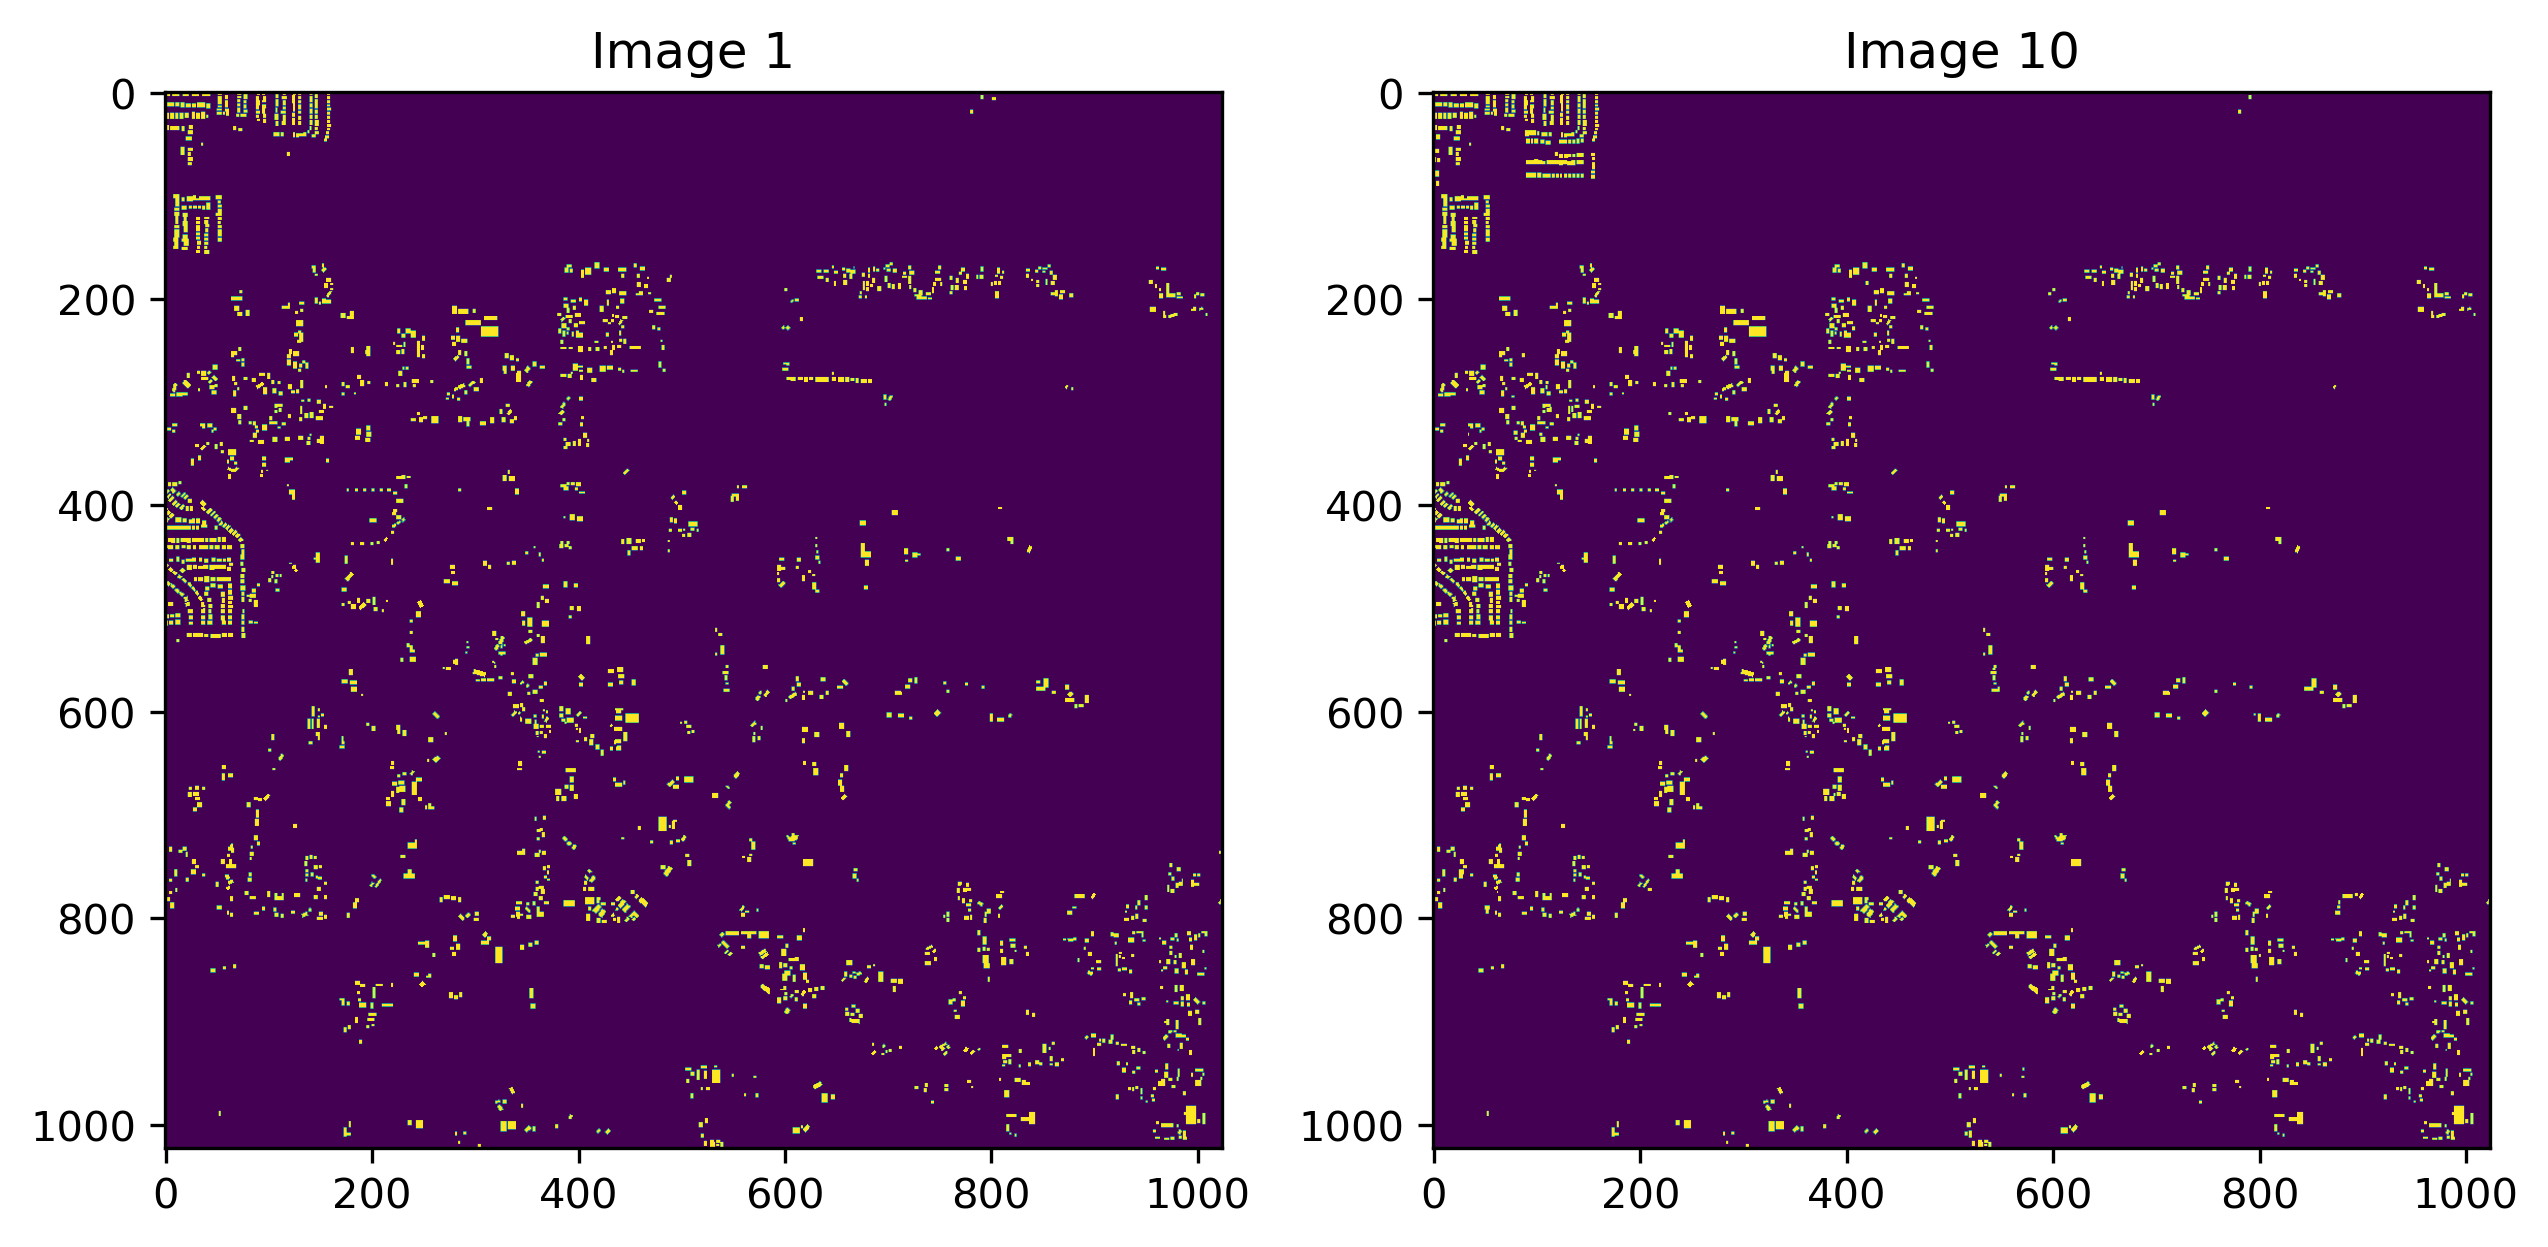

In [59]:
mpl.rcParams['figure.dpi'] = 300
_,axs = plt.subplots(1,2,figsize=(10,10))

masks = [l[0],l[9]]
titles = ['Image 1','Image 10']

for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.imshow(masks[i]);